## Loading Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path
import json
import os

## Graphs

### Functions

In [2]:
def load_to_dataframe(dataset):
    """Convert your JSON structure to analysis-ready DataFrame"""
    BASE_PATH = "drive/MyDrive/Summer2025/w266/Project/results/"
    with open(BASE_PATH + dataset + "_results.json") as f:
        data = json.load(f)

    rows = []
    for epoch, epoch_data in data.items():
        control = epoch_data["control"]
        for layer_type, decile_accs in epoch_data["ablation"].items():
            for decile_idx, acc in enumerate(decile_accs):
                rows.append({
                    "epoch": int(epoch.replace("epoch", "")),
                    "layer_type": layer_type,
                    "decile": decile_idx,
                    "accuracy": acc,
                    "control": control,
                    "drop": control - acc
                })
    return pd.DataFrame(rows)

In [69]:
def plot_sv_ablation(df, epochs, layer_type, plot_drop=False, title=None):
    """
    Plots accuracy or relative drop vs decile removal for multiple epochs and a given layer type.

    Args:
        df (pd.DataFrame): Analysis dataframe with columns:
            ['epoch', 'layer_type', 'decile', 'accuracy', 'control', 'drop']
        epochs (list[int]): List of epochs to visualize
        layer_type (str): Target layer type ('all', 'query', etc.)
        plot_drop (bool): If True, plot relative drop instead of accuracy
        title (str): Optional plot title
    """
    plt.figure(figsize=(3.5, 3))
    plt.style.use('seaborn-v0_8-whitegrid')

    colors = plt.cm.tab10.colors  # default palette

    for i, epoch in enumerate(epochs):
        plot_data = df[(df['epoch'] == epoch) &
                       (df['layer_type'] == layer_type)].copy()
        if plot_data.empty:
            print(f"No data for epoch={epoch}, layer_type={layer_type}")
            continue

        # Sort by decile and extract values
        plot_data = plot_data.sort_values('decile')
        deciles = plot_data['decile'].values + 1  # shift to start at 1
        values = plot_data['drop'].values if plot_drop else plot_data['accuracy'].values

        # Plot each epoch's line
        plt.plot(deciles, values,
                 marker='o', markersize=6,
                 linewidth=2,
                 label=f'Epoch {epoch}',
                 color=colors[i % len(colors)])

    # Axis labels depending on mode
    y_label = 'Relative Accuracy Drop' if plot_drop else 'Validation Accuracy'
    plt.xlabel('Decile Removed', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(range(1, 11))

    # Add informative title if not provided
    if not title:
        mode = "Drop" if plot_drop else "Accuracy"
        title = f"{layer_type.capitalize()} Matrix Across Epochs ({mode})"
    plt.title(title, fontsize=14, pad=20)

    # Configure legend
    plt.legend(
    loc='center left',          # anchor to the left-center of the legend box
    bbox_to_anchor=(1.02, 0.5), # position it just outside the right side of the plot
    ncol=1,                     # single column
    frameon=True,
    fontsize=8
)

    plt.tight_layout()
    plt.show()

In [110]:
def load_ffn_ablation_data(file_path):
    """Load FFN ablation results into a structured DataFrame"""
    with open(file_path) as f:
        data = json.load(f)

    rows = []
    for epoch, epoch_data in data.items():
        epoch_num = int(epoch.replace("epoch", ""))
        control = epoch_data["control"]

        for layer_group, decile_accs in epoch_data["ablation"].items():
            for decile_idx, acc in enumerate(decile_accs):
                rows.append({
                    "epoch": epoch_num,
                    "layer_group": layer_group,
                    "decile": decile_idx + 1,  # 1-10 instead of 0-9
                    "accuracy": acc,
                    "control": control,
                    "drop": control - acc
                })

    return pd.DataFrame(rows)

def plot_ffn_ablation(df, layer_group, plot_drop=True, title=None, name="RTE"):
    """
    Plot FFN ablation results for a specific layer group across epochs

    Args:
        df (pd.DataFrame): Analysis dataframe
        layer_group (str): Target layer group ('0-3', '4-7', '8-11')
        plot_drop (bool): Plot relative drop instead of accuracy
        title (str): Optional plot title
    """
    plt.figure(figsize=(3.5, 3))
    plt.style.use('seaborn-v0_8-whitegrid')

    # Get unique epochs and sort them
    epochs = sorted(df['epoch'].unique())
    colors = plt.cm.tab10.colors

    for epoch, color in zip(epochs, colors):
        plot_data = df[(df['epoch'] == epoch) &
                       (df['layer_group'] == layer_group)].copy()

        if plot_data.empty:
            print(f"No data for epoch={epoch}, layer_group={layer_group}")
            continue

        plot_data = plot_data.sort_values('decile')
        deciles = plot_data['decile'].values
        values = plot_data['drop'].values if plot_drop else plot_data['accuracy'].values

        # Plot each epoch's line
        plt.plot(deciles, values,
                 marker='o', markersize=6,
                 linewidth=2,
                 label=f'Epoch {epoch}',
                 color=color)

    # Configure plot
    y_label = 'Accuracy Drop (control - modified)' if plot_drop else 'Accuracy'
    plt.xlabel('Decile Removed', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.xticks(range(1, 11))

    if not title:
        title = f"{name} - FFN Layers {layer_group}"
    plt.title(title, fontsize=14, pad=15)

    plt.legend(
    loc='center left',          # anchor to the left-center of the legend box
    bbox_to_anchor=(1.02, 0.5), # position it just outside the right side of the plot
    ncol=1,                     # single column
    frameon=True,
    fontsize=8
    )

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_ffn_ablation_subplots(df, layer_groups, plot_drop=True, name="RTE"):
    epochs = sorted(df['epoch'].unique())
    colors = plt.cm.tab10.colors
    y_label = 'Accuracy Drop (control - modified)' if plot_drop else 'Accuracy'

    fig, axes = plt.subplots(1, len(layer_groups), figsize=(6, 3), sharey=True)
    plt.style.use('seaborn-v0_8-whitegrid')

    for ax, layer_group in zip(axes, layer_groups):
        for epoch, color in zip(epochs, colors):
            plot_data = df[(df['epoch'] == epoch) & (df['layer_group'] == layer_group)].copy()
            if plot_data.empty:
                print(f"No data for epoch={epoch}, layer_group={layer_group}")
                continue

            plot_data = plot_data.sort_values('decile')
            deciles = plot_data['decile'].values
            values = plot_data['drop'].values if plot_drop else plot_data['accuracy'].values

            ax.plot(deciles, values,
                    marker='o', markersize=6,
                    linewidth=2,
                    label=f'Epoch {epoch}',
                    color=color)

        ax.set_title(f"FFN Layers {layer_group}", fontsize=12, pad=10)
        ax.set_xlabel('Decile Removed', fontsize=11)
        ax.set_xticks(range(1, 11))
        ax.grid(True, alpha=0.3)

    # Adjust layout to make room on the left for y-label
    plt.subplots_adjust(left=0.15, right=0.85)

    # Add one shared y-label on the left side
    fig.text(-0.005, 0.5, y_label, va='center', rotation='vertical', fontsize=12)

    # Create one shared legend outside the subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.959, 0.5), fontsize=9)

    #fig.suptitle(f"{name} - FFN Layer Groups", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# Call it

### Plots

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
df_imdb = load_to_dataframe('imdb')
df_rte  = load_to_dataframe('rte')
df_qqp  = load_to_dataframe('qqp')
df_qnli = load_to_dataframe('qnli')
df_mnli = load_to_dataframe('mnli')

PATH = "drive/MyDrive/Summer2025/w266/Project/results/"
imdb_layer = load_ffn_ablation_data(PATH + "imdb" + "_layer_results.json")
rte_layer = load_ffn_ablation_data(PATH + "rte" + "_layer_results.json")
qqp_layer = load_ffn_ablation_data(PATH + "qqp" + "_layer_results.json")
qnli_layer = load_ffn_ablation_data(PATH + "qnli" + "_layer_results.json")
mnli_layer = load_ffn_ablation_data(PATH + "mnli" + "_layer_results.json")

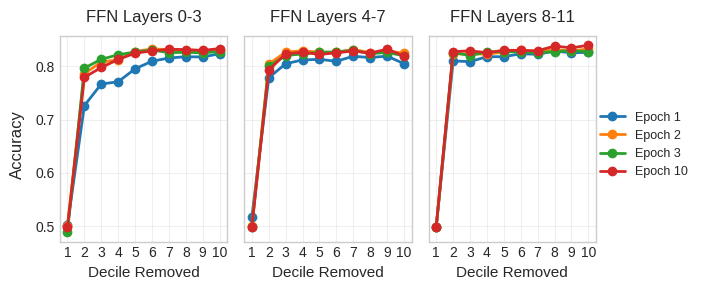

In [132]:
plot_ffn_ablation_subplots(qnli_layer, ['0-3', '4-7', '8-11'], plot_drop=False, name="QNLI")

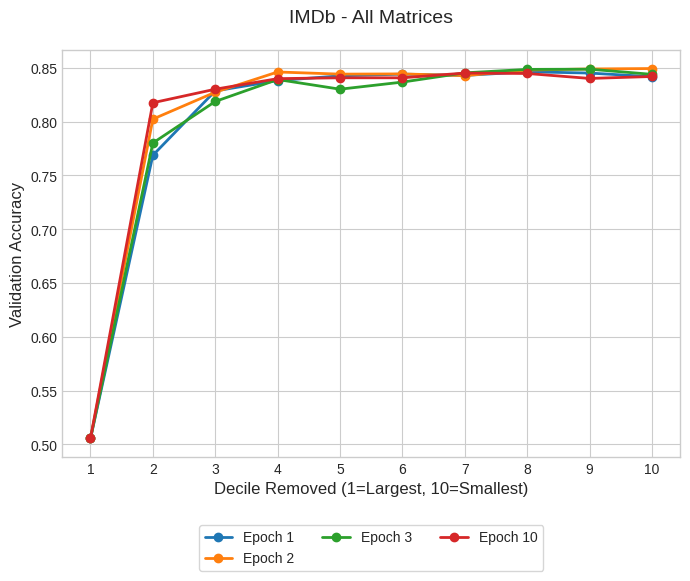

In [ ]:
plot_sv_ablation(df_imdb, epochs=[1, 2, 3, 10], layer_type='all',
                 plot_drop=False,
                 title="IMDb - All Matrices")

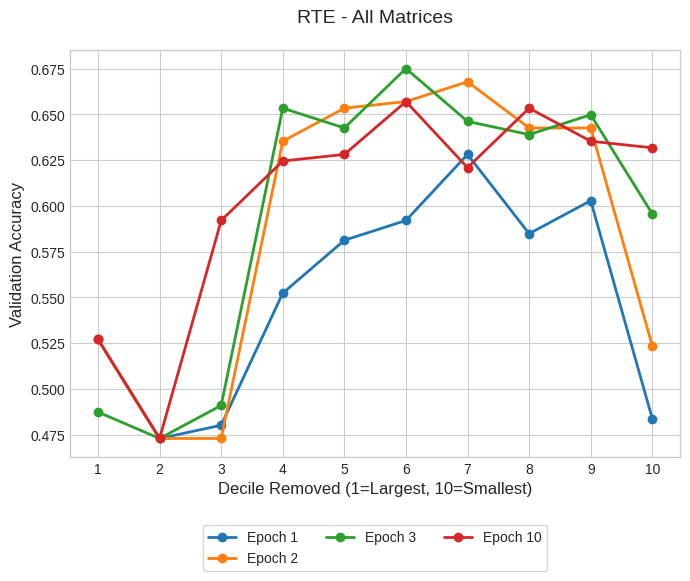

In [ ]:
plot_sv_ablation(df_rte, epochs=[1, 2, 3, 10], layer_type='all',
                 plot_drop=False,
                 title="RTE - All Matrices")

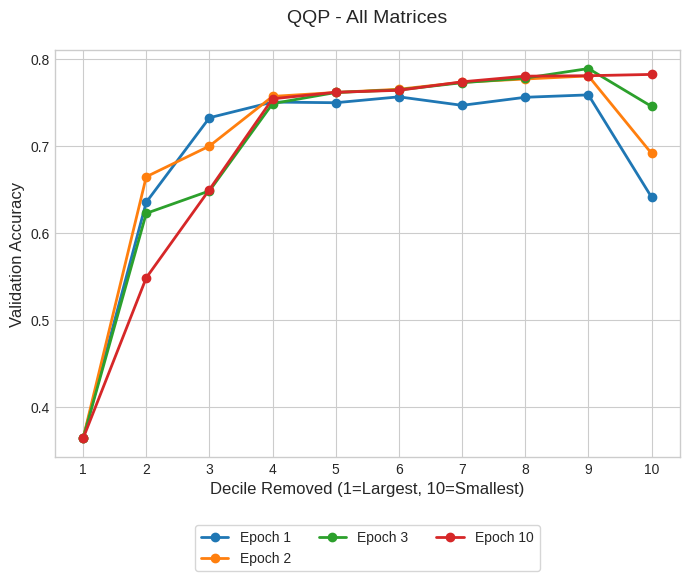

In [ ]:
plot_sv_ablation(df_qqp, epochs=[1, 2, 3, 10], layer_type='all',
                 plot_drop=False,
                 title="QQP - All Matrices")

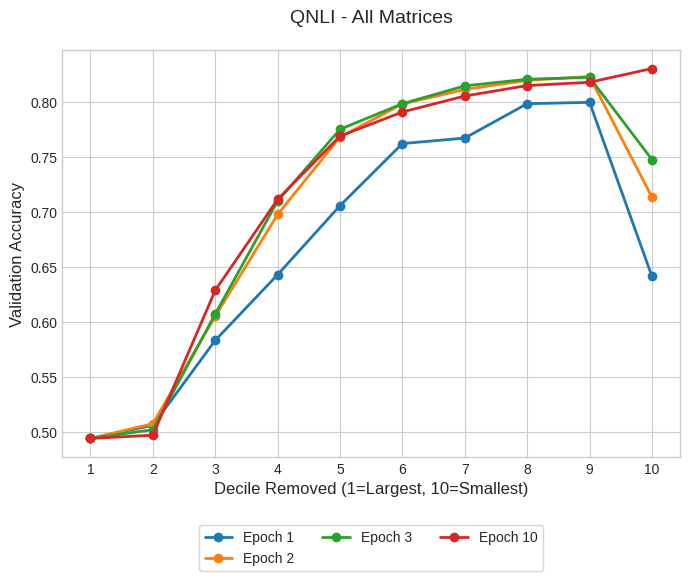

In [ ]:
plot_sv_ablation(df_qnli, epochs=[1, 2, 3, 10], layer_type='all',
                 plot_drop=False,
                 title="QNLI - All Matrices")

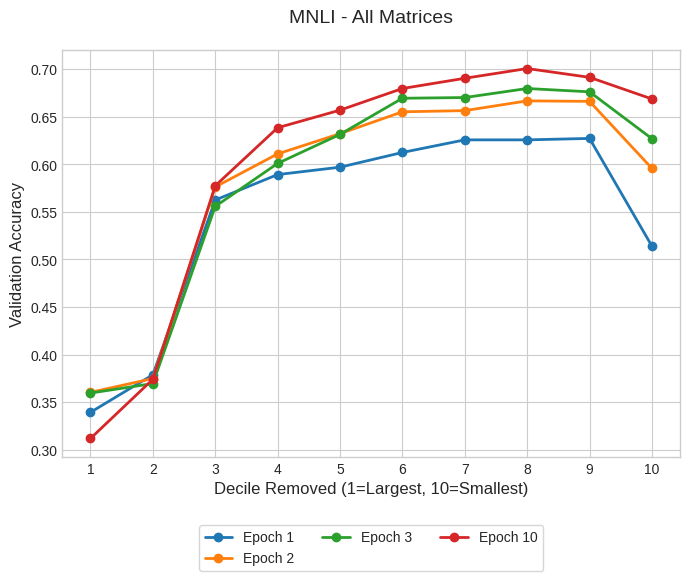

In [ ]:
plot_sv_ablation(df_mnli, epochs=[1, 2, 3, 10], layer_type='all',
                 plot_drop=False,
                 title="MNLI - All Matrices")

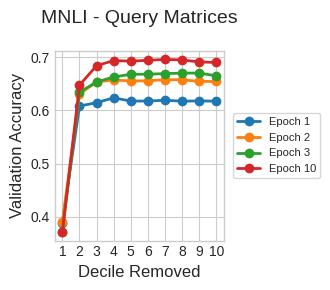

In [70]:
plot_sv_ablation(df_mnli, epochs=[1, 2, 3, 10], layer_type='query',
                 plot_drop=False,
                 title="MNLI - Query Matrices")

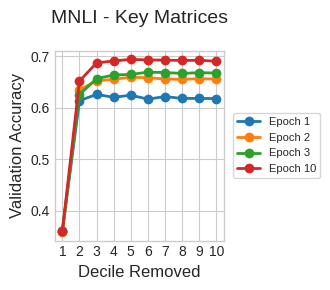

In [71]:
plot_sv_ablation(df_mnli, epochs=[1, 2, 3, 10], layer_type='key',
                 plot_drop=False,
                 title="MNLI - Key Matrices")

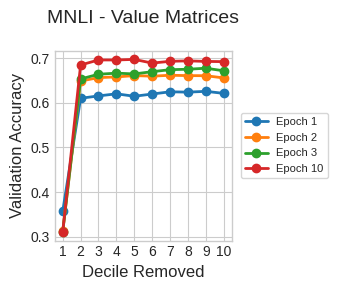

In [72]:
plot_sv_ablation(df_mnli, epochs=[1, 2, 3, 10], layer_type='value',
                 plot_drop=False,
                 title="MNLI - Value Matrices")

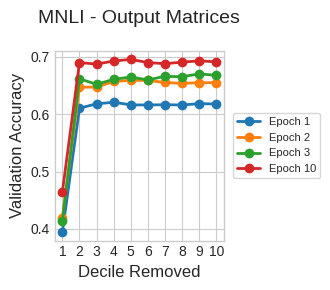

In [73]:
plot_sv_ablation(df_mnli, epochs=[1, 2, 3, 10], layer_type='output',
                 plot_drop=False,
                 title="MNLI - Output Matrices")

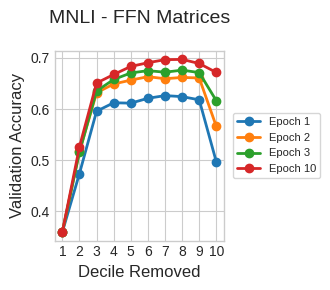

In [74]:
plot_sv_ablation(df_mnli, epochs=[1, 2, 3, 10], layer_type='ffn',
                 plot_drop=False,
                 title="MNLI - FFN Matrices")

In [ ]:
def plot_final_decile_drop(dfs, dataset_names, epoch, layer_type='all', relative=True, title=None):
    """
    Plots a bar chart of the accuracy drop at decile 9 for multiple datasets.

    Args:
        dfs (list[pd.DataFrame]): List of dataframes (one per dataset)
        dataset_names (list[str]): Names corresponding to each dataframe
        epoch (int): Epoch to filter by
        layer_type (str): Layer type to filter by (default 'all')
        relative (bool): If True, plot relative drop (fraction of control). If False, plot absolute drop.
        title (str): Optional title for the plot
    """
    drops = []

    for df in dfs:
        # Filter for chosen epoch, layer, and final decile (9)
        filtered = df[(df['epoch'] == epoch) &
                      (df['layer_type'] == layer_type) &
                      (df['decile'] == 9)]
        if filtered.empty:
            drops.append(None)
        else:
            drop = filtered['drop'].values[0]
            control = filtered['control'].values[0]
            drops.append(drop / control if relative else drop)

    # Create bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(dataset_names, drops, color=plt.cm.tab10.colors)

    # Labels and title
    y_label = 'Relative Accuracy Drop (Fraction of Baseline)' if relative else 'Absolute Accuracy Drop'
    plt.ylabel(y_label, fontsize=12)
    plt.xlabel('Dataset', fontsize=12)
    if not title:
        mode = "Relative" if relative else "Absolute"
        title = f'{mode} Accuracy Drop at Decile 9 | Epoch {epoch} | Layer: {layer_type}'
    plt.title(title, fontsize=14)

    # Add value labels on bars
    for i, v in enumerate(drops):
        if v is not None:
            plt.text(i, v + 0.005, f"{v:.3f}", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()


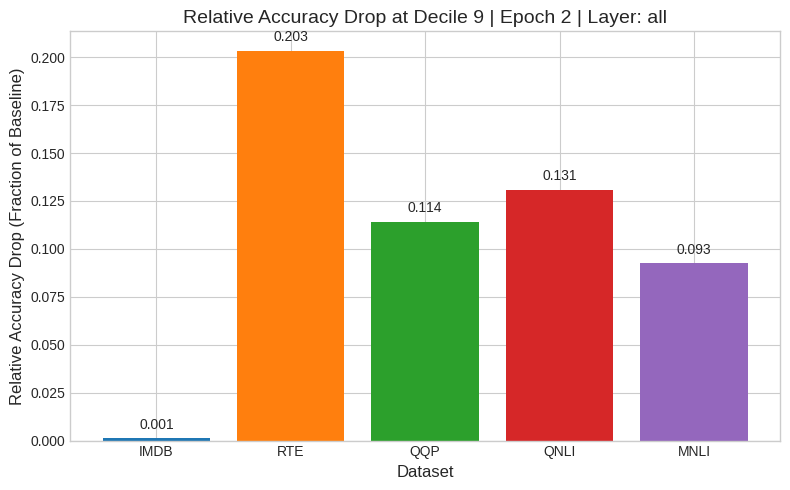

In [ ]:
dfs = [df_imdb, df_rte, df_qqp, df_qnli, df_mnli]
names = ['IMDB', 'RTE', 'QQP', 'QNLI', 'MNLI']

plot_final_decile_drop(dfs, names, layer_type='all', epoch=2,
                       relative=True,
                       title=None)

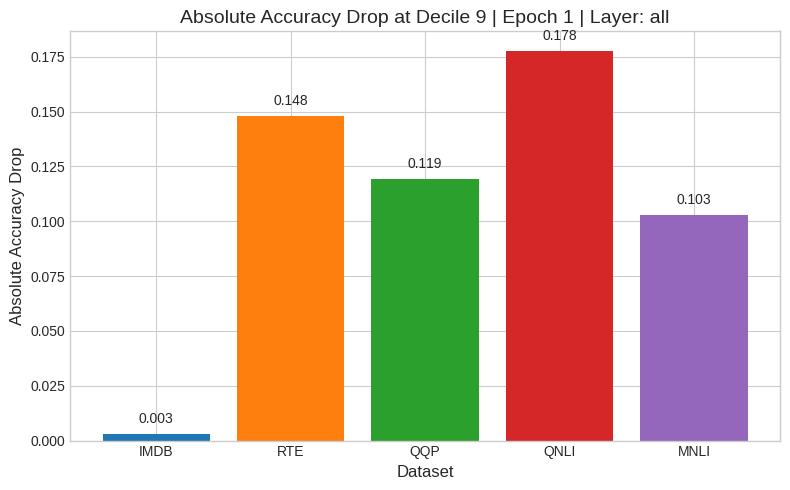

In [ ]:
plot_final_decile_drop(dfs, names, layer_type='all', epoch=1,
                       relative=False,
                       title=None)

### Tables/Heatmaps

In [47]:
def create_decile_heatmap(epoch: int, layer_type: str):
    """Create a heatmap showing accuracy drop by dataset and SV decile removed.

    Args:
        epoch: Model epoch number (1, 2, 3, 10)
        layer_type: Matrix type ('all', 'ffn', 'query', 'key', 'value', 'output')
    """
    # Load datasets into dictionary
    datasets = {
        'IMDb': df_imdb,
        'RTE': df_rte,
        'QQP': df_qqp,
        'QNLI': df_qnli,
        'MNLI': df_mnli
    }

    # Prepare empty results matrix
    results = pd.DataFrame(
        index=datasets.keys(),
        columns=[f'{i+1}' for i in range(10)]
    )

    # Populate results matrix
    for dataset, df in datasets.items():
        # Filter for specified epoch and layer type
        filtered = df[
            (df['epoch'] == epoch) &
            (df['layer_type'] == layer_type)
        ].sort_values('decile')

        # Ensure we have exactly 10 deciles
        if len(filtered) != 10:
            print(f"Warning: {dataset} has {len(filtered)} decile records for epoch {epoch}, layer {layer_type}")
            continue

        # Convert drop to percentage points
        results.loc[dataset] = filtered['drop'].values * 100

    # Create heatmap
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(
        results.astype(float),
        annot=True,
        fmt=".1f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        annot_kws={"size": 10},
        cbar=False
    )

    # Formatting
    plt.title(f"Accuracy Drop Relative to Baseline\nEpoch {epoch}, Layer Type: {layer_type}", fontsize=14)
    plt.ylabel("Dataset", fontsize=12)
    plt.xlabel("SV Decile Removed", fontsize=12)
    plt.xticks(rotation=0)

    # Add colorbar label
    # cbar = ax.collections[0].colorbar
    # cbar.set_label('Accuracy Drop %', rotation=270, labelpad=20)

    plt.tight_layout()
    plt.savefig(f"decile_heatmap_epoch{epoch}_{layer_type}.png", dpi=300)
    plt.show()

    return results

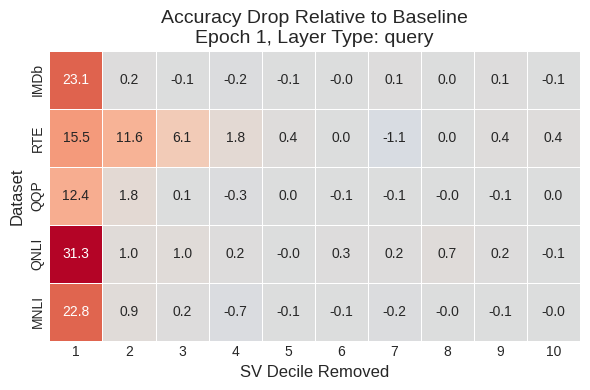

              1          2         3         4         5      6         7  \
IMDb      23.14       0.22     -0.12     -0.24      -0.1  -0.02      0.08   
RTE   15.523466  11.552347  6.137184  1.805054  0.361011    0.0 -1.083032   
QQP      12.375      1.825      0.05      -0.3       0.0 -0.125    -0.125   
QNLI     31.325      1.025       1.0     0.225     -0.05    0.3     0.225   
MNLI     22.825        0.9      0.25     -0.65     -0.05  -0.05      -0.2   

          8         9        10  
IMDb   0.04      0.12     -0.06  
RTE     0.0  0.361011  0.361011  
QQP  -0.025    -0.125     0.025  
QNLI  0.725     0.225      -0.1  
MNLI -0.025    -0.075    -0.025  


In [133]:
heatmap_table = create_decile_heatmap(epoch=1, layer_type='query')
print(heatmap_table)

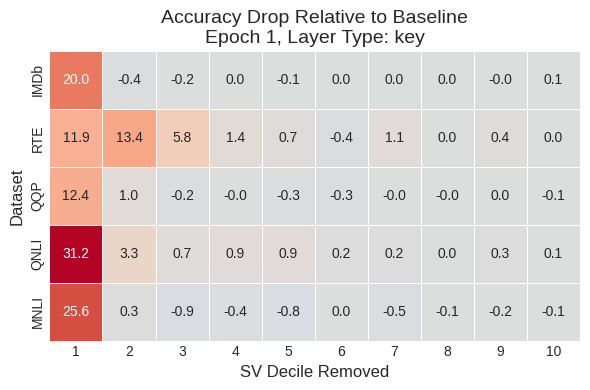

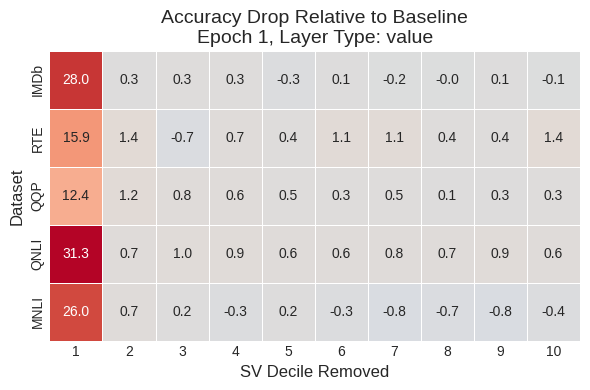

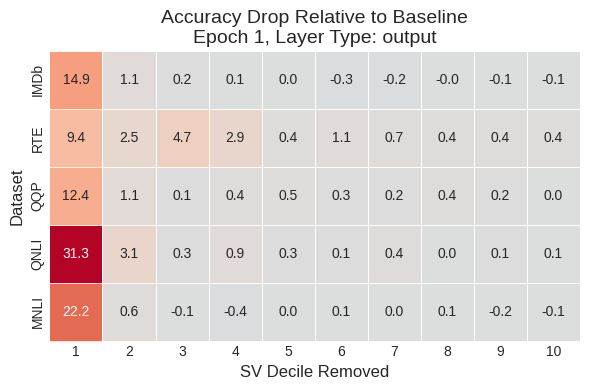

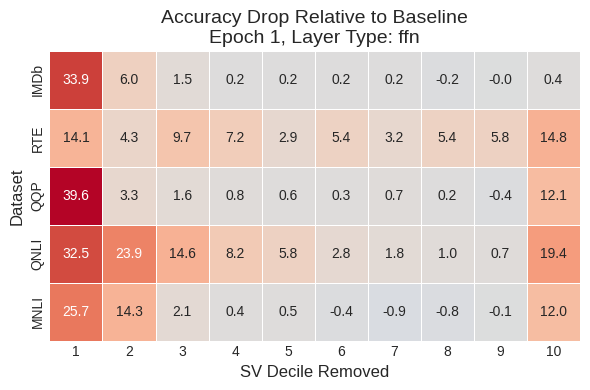

In [134]:
heatmap_table = create_decile_heatmap(epoch=1, layer_type='key')
heatmap_table = create_decile_heatmap(epoch=1, layer_type='value')
heatmap_table = create_decile_heatmap(epoch=1, layer_type='output')
heatmap_table = create_decile_heatmap(epoch=1, layer_type='ffn')